# <center>TMVA Classification Using Deep Neural Networks</center>

In this notebook we still classify di-Higgs new data with Deep Neural Networks meethod.

In [1]:
import ROOT
from ROOT import TMVA, TTree
import pandas as pd

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

import itertools

Welcome to JupyROOT 6.14/04


Using TensorFlow backend.


### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [2]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [3]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "SR_1tag", "Xtohh1000")

In [4]:
outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

#signal_tree.Print()

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

We have two kinds of signals and for the training we have to use only one of them.

In [5]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree )
loader.AddBackgroundTree( backg_tree )
loader.SetSignalWeightExpression("EventWeight")

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.

In [6]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=2000:nTrain_Background=800:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## DNN

In [7]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

In [8]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='sigmoid', input_dim=10))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________


In [9]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=G:FilenameModel=model_dense.h5:'+\
        'NumEpochs=10:BatchSize=16:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0x8331c10>

## Train Model

In [10]:
factory.TrainAllMethods()

/home/andrea/anaconda3/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2800 samples, validate on 10015 samples
Epoch 1/10
2800/2800 [==============================] - 3s 916us/step - loss: 0.4916 - categorical_accuracy: 0.7704 - val_loss: 0.7297 - val_categorical_accuracy: 0.6251

Epoch 00001: val_loss improved from inf to 0.72968, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/10
2800/2800 [==============================] - 2s 537us/step - loss: 0.4324 - categorical_accuracy: 0.8132 - val_loss: 0.6737 - val_categorical_accuracy: 0.6734

Epoch 00002: val_loss improved from 0.72968 to 0.67373, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 3/10
2800/2800 [==============================] - 1s 514us/step - loss: 0.4220 - categorical_accuracy: 0.8236 - val_loss: 0.8488 - val_categorical_accuracy: 0.5835

Epoch 00003: val_loss did not improve from 0.67373
Epoch 4/10
2800/2800 [==============================] - 1s 513us/step - loss: 0.4103 - categorical_accuracy: 0.8300 - val_loss: 0.5878 - val_categorical_accura

## Test  Model

Here we test all methods using the test data set

In [11]:
factory.TestAllMethods()

## Evaluate Model

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [12]:
factory.EvaluateAllMethods()

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       Keras_Dense    : 0.877
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

## Plot ROC Curve
We enable JavaScript visualisation for the plots

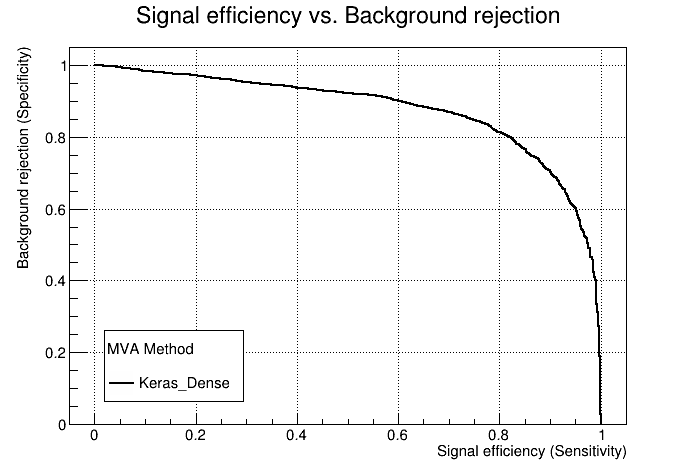

In [13]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## DNN Complete Function

In [17]:
def get_params(file):
    params = []
    first = 1
    with open(file, 'r') as fp:
        line = fp.readline().rstrip()
        while line:
            if (file.split('.')[1] == 'csv' and first):
                first = 0
                line = fp.readline().rstrip()
                continue
            params.append(line)
            line = fp.readline().rstrip()       
    return params

In [18]:
def DNN(params, training, model_input, comp_params, model_name, config):
    
    output_file = config+"_DNN_Classification.root"
    signal_file = config+"_s.root"
    backg_file = config+"_b.root"
    
    signal_input = ROOT.TFile(signal_file)
    signal_tree = signal_input.Nominal
    
    backg_input = ROOT.TFile(backg_file)
    backg_tree = backg_input.Nominal
    
    outputFile = ROOT.TFile.Open(output_file, "RECREATE")

    # Factory
    factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                          "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

    loader = ROOT.TMVA.DataLoader("dataset")

    ### global event weights per tree (see below for setting event-wise weights)
    #signalWeight     = 1.0
    #backgroundWeight = 1.0

    ### You can add an arbitrary number of signal or background trees
    loader.AddSignalTree    ( signal_tree )
    loader.AddBackgroundTree( backg_tree )
    loader.SetSignalWeightExpression("EventWeight")
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

    ## Define input variables 
    for branch in backg_tree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        loader.AddVariable(branch.GetName())
        
    mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
    mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


    loader.PrepareTrainingAndTestTree(mycuts, mycutb, training)
    
    # Model structure
    
    comp_params = comp_params.rstrip()
    comp_params = comp_params.split(',')
    loss = comp_params[0]
    
    comp_params.remove(loss)
    metrics = comp_params
    
    model = Sequential()
    model_input = model_input.rstrip()
    model_input = model_input.split(',')
    
    hidden_l = int(model_input[0])
    neurons = int(model_input[1])
    neurons_LF = int(model_input[2])
    k_init = model_input[3]
    activation_IL = model_input[4]
    activation_HL = model_input[5]
    activation_FL = model_input[6]
    
    print(type(neurons))
    
    model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_IL, input_dim=10))
    for h in range(hidden_l):
        model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_HL))
        
    model.add(Dense(neurons_LF, kernel_initializer=k_init, activation=activation_FL))
    
    # Set loss and optimizer
    model.compile(loss=loss, optimizer=Adam(), metrics=metrics)
    # Store model to file
    model.save(model_name)
    # Print summary of model
    model.summary()
    
    ## DNN method
    factory.BookMethod(loader,ROOT.TMVA.Types.kPyKeras, "Keras_Dense", params)
        
    factory.TrainAllMethods()
    
    factory.TestAllMethods()
    
    factory.EvaluateAllMethods()
    
    c1 = factory.GetROCCurve(loader)
    #c1.Draw()
    
    integ = factory.GetROCIntegral(loader, "Keras_Dense")
    
    print("ROC integral:", integ)
    
    outputFile.Close()
    signal_input.Close()
    backg_input.Close()
    
    return integ

## Parameters Combination

In [19]:
def write_combs_params(file_params, file_training, file_model, comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics):
    comb_params = list(itertools.product(arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics))
    with open(file_params, 'w') as params, open(file_training, 'w') as training, open(file_model, 'w') as model, open(comp_params, 'w') as comp_p:
        model.write("number_HL,neurons,neurons_LF,k_init,activation_IL,activation_HL,activation_FL\n")
        for cp in comb_params:
            string1 = "H:!V:VarTransform=N_AllClasses:FilenameModel="+model_name+":NumEpochs="+str(cp[0])+":BatchSize="+str(cp[1])+":TriesEarlyStopping=10\n"
            params.write(string1)
            string2 = "nTrain_Signal="+str(cp[2])+"%:nTrain_Background="+str(cp[3])+"%:SplitMode=Random:NormMode=NumEvents:!V\n"
            training.write(string2)
            string3 = str(cp[4])+','+str(cp[5])+','+str(cp[6])+','+str(cp[7])+','+str(cp[8])+','+str(cp[9])+','+str(cp[10])+'\n'
            model.write(string3)
            string4 = str(cp[11])+','+str(cp[12])+'\n'
            comp_p.write(string4)

In [20]:
file_params="dnn_params2.txt"
file_training="dnn_training2.txt"
file_model="dnn_model2.csv"
file_comp_params='comp_params.txt'
model_name="model_dense.h5"
arr_NumEpochs=[10]
arr_BatchSize=[100, 200]
arr_nTrain_Signal=[80]
arr_nTrain_Background=[80]
arr_number_HL=[3]
arr_neurons=[64]
arr_neurons_LF=[2]
arr_k_init=['glorot_normal']
arr_activation_IL=['sigmoid']
arr_activation_HL=['relu']
arr_activation_FL=['softmax']
arr_loss=['categorical_crossentropy']
arr_metrics=['categorical_accuracy']

In [21]:
write_combs_params(file_params, file_training, file_model, file_comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics)

## Hyperparameter Optimization

In [22]:
def param_opt(config, params, training, model, comp_params, model_name):
    max_roc = 0
    best_params = ""
    best_train = ""
    best_model = ""
    print(config)
    print("===============")
    for i in range(len(params)):
        roc = DNN(params[i], training[i], model[i], comp_params[i], model_name, config)
        if roc > max_roc:
            max_roc = roc
            best_params = params[i]
            best_train = training[i]
            best_model = model[i]
    best_model = best_model.split(',')
    best_model_str = "numero_HL="+str(best_model[0])+", neurons="+str(best_model[1])+", neurons_LF="+str(best_model[2])+", k_init="+str(best_model[3])+", activation_IL="+str(best_model[4])+", activation_HL="+str(best_model[5])+", activation_FL="+str(best_model[6])
    print("best parameters:", best_params)
    print("best training:", best_train)
    print("best model:", best_model_str)
    print("ROC integral:", max_roc)
    return

In [23]:
params_path = "dnn_params2.txt"
params = get_params(params_path)
training_path = "dnn_training2.txt"
training = get_params(training_path)
configs = ["PreSel_0tag_Xtohh1000", "PreSel_1tag_Xtohh1000", "PreSel_2tag_Xtohh1000", 
           "QCDCR_0tag_Xtohh1000", "QCDCR_1tag_Xtohh1000", "QCDCR_2tag_Xtohh1000",
           "SR_0tag_Xtohh1000", "SR_1tag_Xtohh1000", "SR_2tag_Xtohh1000",
           "PreSel_0tag_Xtohh2000", "PreSel_1tag_Xtohh2000", "PreSel_2tag_Xtohh2000",
           "QCDCR_0tag_Xtohh2000", "QCDCR_1tag_Xtohh2000", "QCDCR_2tag_Xtohh2000",
           "SR_0tag_Xtohh2000", "SR_1tag_Xtohh2000", "SR_2tag_Xtohh2000"]
s_end = "_s.root"
b_end = "_b.root"
comp_params_path = "comp_params.txt"
comp_params = get_params(comp_params_path)
model_input_path = "dnn_model2.csv"
model_input = get_params(model_input_path)
model_name = "model_dense.h5"

In [24]:
param_opt(configs[2], params, training, model_input, comp_params, model_name)

PreSel_2tag_Xtohh1000
<class 'int'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________
Train on 160 samples, validate on 5178 samples
Epoch 1/10
160/160 [==============================] - 1

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0
